In [5]:
import torch
from torch.nn import MSELoss, Module
import spacy
from nltk.corpus import wordnet as wn
import numpy as np
import pandas as pd
import json

In [6]:
def get_batches(data, batch_size):
    #converting data to batches
    no_of_batches = len(data) // batch_size
    
    for n in range(0, len(data), no_of_batches):
        
        try:
            
            x1 = data.sent_1.iloc[n:n + no_of_batches].values
            x2 = data.sent_2.iloc[n:n + no_of_batches].values
            Y = data.score.iloc[n:n + no_of_batches].values
        
        except IndexError:
            
            x1 = data.sent_1.iloc[n:].values
            x2 = data.sent_2.iloc[n:].values
            Y = data.score.iloc[n:].values
    
    yield x1, x2, Y

In [7]:
class TextSimilarity():
    
    def __init__(self, tags_dict = None, correlation_matrix = None):
        
        self._tags = self._get_tags_dict() if tags_dict is None else tags_dict
        self._no_of_tags = len(self._tags)
#         TODO: initialize matrix to identity, random, zeros
        self._tag_correlation_matrix = np.identity(self._no_of_tags) if correlation_matrix is None else correlation_matrix
        self._parser = spacy.load('en_core_web_sm')
        
    def _get_tags_dict(self):
        
        with open("data/tags.json","r") as fl:
            tags = json.load(fl)
            
        return tags
    
    def _similarity_word(self, pair_A, pair_B):

        #getting head and dependent texts 
        head_a, head_b = pair_A[0].text, pair_B[0].text
        dep_a, dep_b = pair_A[2].text, pair_B[2].text

        if head_a == head_b:
            head = 1
        else:
            try:
                #WordNet synsets for heads
                head_a, head_b = wn.synsets(head_a)[0], wn.synsets(head_b)[0]
                
#                 TODO:Change similarity method
                #path based similarity (Li et. al) for head
                head = head_a.path_similarity(head_b)

                head = 0 if head is None else head  

            except Exception:
                head = 0

        if dep_a == dep_b:
            dep = 1
        else:
            try:
                #WordNet synsets for dependent
                dep_a, dep_b = wn.synsets(dep_a)[0], wn.synsets(dep_b)[0]
                
#                 TODO:Change similarity method
                #path based similarity (Li et. al) for dependent
                dep = dep_a.path_similarity(dep_b)

                dep = 0 if dep is None else dep

            except Exception:
                dep = 0     

        return head + dep

    def _similarity_tag(self, tag_a, tag_b):
        
        tag_a_id, tag_b_id = self._tags[tag_a], self._tags[tag_b] 
        score = self._tag_correlation_matrix[tag_a_id,tag_b_id]
        
        return score
    
    def semantic_similarity(self, documents_1, documents_2):
        
        #checking the sizes of both documents
        assert len(documents_1) == len(documents_2), "Size of both lists should be same."
        
        #scores vector
        scores = torch.zeros([len(documents_1),],dtype=torch.double)
        
        i = 0
            
        for document_1, document_2 in zip(documents_1,documents_2):
            
            #parsing documets using spaCy English language parser
            tokens_1,tokens_2 = self._parser(document_1), self._parser(document_2)

            #seperating dependency pairs and tags from tokens
            pairs_1 = [(token.head,token.dep_,token) for token in tokens_1]
            pairs_2 = [(token.head,token.dep_,token) for token in tokens_2]

            score = 0

            #calculating score 
            for pair_A in pairs_1:

                for pair_B in pairs_2:

                    score += self._similarity_word(pair_A, pair_B) * self._similarity_tag(pair_A[1], pair_B[1])

            #ranging the score from 0-1 
            score = torch.sigmoid(score)
            
            scores[i] += score
            
            i += 1

        return scores 

In [8]:
def save_model(tags_matrix_tensor, train_name):
    
    tags_matrix = tags_matrix_tensor.detach().numpy()
    
    #tags_matrix.save(f"models/{train_name}")
    np.save(f"models/{train_name}", tags_matrix)
    
    print(f"Model {train_name} saved.")

In [9]:
def train(data, model, train_name, epochs = 25, lr = 0.001, validation_thresh = 0.2, batch_size = 10, print_every = 5):
    
    model._tag_correlation_matrix = torch.from_numpy(model._tag_correlation_matrix)
    model._tag_correlation_matrix.requires_grad = True
    
    criterion = MSELoss()
    optimizer = torch.optim.Adam([model._tag_correlation_matrix], lr=lr)
    
    thresh = int(validation_thresh * len(data))
    
    train_data = data.iloc[:thresh]
    valid_data = data.iloc[thresh:]
    
    train_losses = []
    valid_losses = []
    count = 0
    
    for epoch in range(epochs):
        
        losses = []
        
        for x1, x2, Y in get_batches(train_data, batch_size):
            
            count += 1
        
            scores = model.semantic_similarity(x1, x2)
            
            Y = torch.DoubleTensor(Y)
            
            loss = criterion(scores, Y)
            
            losses.append(loss.item())
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            
            if count % print_every == 0:
                
                train_losses.append(np.mean(losses))
                losses = []
                
                for x1, x2, Y in get_batches(valid_data, batch_size):
                    
                    scores = model.semantic_similarity(x1, x2)
                    
                    Y = torch.DoubleTensor(Y)
                    
                    loss = criterion(scores, Y)

                    losses.append(loss.item())
                    
                valid_losses.append(np.mean(losses))
                
                print(f"{count} {epoch}/{epochs}\ttraining loss:{train_losses[-1]}\tvalididation loss:{valid_losses[-1]}") 
    
    save_model(model._tag_correlation_matrix, train_name)
    return train_losses,valid_losses

In [10]:
data = pd.read_csv("data/STS_Final.csv",index_col=None)
data.head()

,Unnamed: 0,sent_1,sent_2,score
0,0,The problem likely will mean corrective change...,He said the problem needs to be corrected befo...,0.88
1,1,The technology-laced Nasdaq Composite Index .I...,The broad Standard & Poor's 500 Index .SPX inc...,0.16
2,2,"""It's a huge black eye,"" said publisher Arthur...","""It's a huge black eye,"" Arthur Sulzberger, th...",0.72
3,3,SEC Chairman William Donaldson said there is a...,"""I think there's a building confidence that th...",0.68
4,4,Vivendi shares closed 1.9 percent at 15.80 eur...,"In New York, Vivendi shares were 1.4 percent d...",0.28


In [11]:
model = TextSimilarity()
data = data.sample(frac=1).reset_index(drop=True)
thresh = int(0.8 * len(data))#limiting test data

train_data = data.iloc[:thresh]#train data
test_data = data.iloc[thresh:]#test data

In [12]:
#TODO: change epoch, lr, batch_size
epoch = 250
lr = 0.001
batch_size = 50
train_name = "a2" #cell name for which training is done 

train_losses,valid_losses = train(train_data, model, train_name, epochs=epoch, lr=lr, batch_size = batch_size)

5 4/250	training loss:0.3280753977937205	valididation loss:0.22618992300647284
10 9/250	training loss:0.32769437780420413	valididation loss:0.22616648529659703
15 14/250	training loss:0.32726661329893764	valididation loss:0.22614173198957782
20 19/250	training loss:0.32678341099344155	valididation loss:0.22611540250677659
25 24/250	training loss:0.32623479291792173	valididation loss:0.2260872170657588
30 29/250	training loss:0.3256095397266634	valididation loss:0.22605687470556143
35 34/250	training loss:0.3248953145832301	valididation loss:0.22602404843132481
40 39/250	training loss:0.32407893190090353	valididation loss:0.2259883775977775
45 44/250	training loss:0.3231468629969396	valididation loss:0.2259494575708626
50 49/250	training loss:0.3220860939172384	valididation loss:0.22590682639025822
55 54/250	training loss:0.3208854593937136	valididation loss:0.22585994767316042
60 59/250	training loss:0.31953755205629564	valididation loss:0.22580818838405256
65 64/250	training loss:0.31

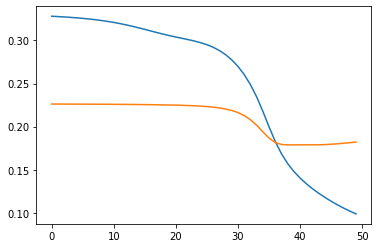

In [13]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(valid_losses)
plt.savefig(f"plots/{train_name}", format = "png")
plt.show()

In [14]:
tag_correlation_matrix =np.load('models/a2.npy')

In [15]:
tag_correlation_matrix

array([[ 0.56344099, -0.22282616,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.40789886,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

In [34]:
test_Y = torch.DoubleTensor(test_Y.values)
loss = loss(scores,test_Y)
loss.item() # value to be stored in cell

NameError: name 'test_Y' is not defined

In [ ]:
for each in []: